# 13.2 終点誤差分散最小モデル (minimum-variance model)
終点誤差分散最小モデル (minimum-variance model; Harris & Wolpert, 1998)を実装する．

## 13.2.1 等式制約下での二次計画法 (Equality Constrained Quadratic Programming)

以下，wikipediaより引用（後日改訂）

二次計画問題は行列 Q が正値定符号であり、等式制約のみを含む時、特に簡単になり、解の過程は線形となる。ラグランジュの未定乗数法を用い、ラグランジアンの極値を探せば、以下の等式制約問題

$$
\begin{align}
&{\text{Minimize}}\quad {\frac {1}{2}}\mathbf {x} ^\top P\mathbf {x} +\mathbf {q} ^{\top}\mathbf {x}\\
&{\text{subject to}}\quad A\mathbf {x} =\mathbf {b}
\end{align}
$$

の解は次の線形システム

$$
{\begin{bmatrix}P&A^\top\\A&0\end{bmatrix}}{\begin{bmatrix}\mathbf {x} \\
\lambda \end{bmatrix}}={\begin{bmatrix}-\mathbf {q} \\\mathbf {b} \end{bmatrix}}
$$

の解として与えられることが容易に示される。ここで $\lambda$  はラグランジュ乗数の集合で x と共に計算される。

In [1]:
using LinearAlgebra, Random, ToeplitzMatrices, PyPlot

In [2]:
# Equality Constrained Quadratic Programming
function solveEqualityConstrainedQuadProg(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])]
    sol = K^-1 * [-q; b]
    return sol[1:size(A)[2]]
end

solveEqualityConstrainedQuadProg (generic function with 1 method)

In [3]:
P = diagm([1.0, 0.0])
q = [3.0, 4.0]
A = [1.0, 1.0]'
b = [1.0]
x = solveEqualityConstrainedQuadProg(P, q, A, b)

2-element Vector{Float64}:
 1.0
 0.0

## 13.2.2 終点誤差分散最小モデルの実装
サッカードするときの眼球運動のシミュレーションを行う．

> Yazdani M, Gamble G, Henderson G, Hecht-Nielsen R. A simple control policy for achieving minimum jerk trajectories. Neural Netw. 2012;27:74–80. doi:10.1016/j.neunet.2011.11.005

を参考に作成 (元はPythonでcvxoptを用いた実装)．MATLABの場合は田中先生の<https://motorcontrol.jp/mc13/MC2019_2_OptimalControlStochastic.pdf>にコードが記載してある．

In [4]:
# setup sample rate
nt = 100 # number of samples
dt = 1.0/nt # sample rate
n = range(0, 1, length=nt); #one second worth of samples

In [5]:
row_jerk = [[-1, 3, -3, 1]; zeros(nt-4)]
col_jerk = [-1; zeros(nt-4)];
D_jerk = Toeplitz(col_jerk, row_jerk);

In [6]:
init_pos = [1; zeros(nt-1)]'
final_pos = [zeros(nt-1); 1]'
init_vel = [[-1, 1]; zeros(nt-2)]'
final_vel = [zeros(nt-2); [-1, 1]]'
init_accel = [[1, -2, 1]; zeros(nt-3)]'
final_accel = [zeros(nt-3); [1, -2, 1]]';

Aeq = [init_pos; final_pos; init_vel; final_vel; init_accel; final_accel];

beq = zeros(6) # (init or final) or (pos, vel, acc) = 2*3
beq[1] = 0 # initial position (m)
beq[2] = 2; # final position (m) 

二次計画法を解く．

In [7]:
sol_pos = solveEqualityConstrainedQuadProg(D_jerk' * D_jerk, zeros(nt), Aeq, beq);

位置解を速度，加速度，躍度に変換する．

In [8]:
# set D_vel and D_accel
row_vel = [[-1, 1]; zeros(nt-2)]
col_vel = [-1; zeros(nt-2)]
D_vel = nt * Toeplitz(col_vel, row_vel);

row_accel = [[1,-2,1]; zeros(nt-3)] 
col_accel = [1; zeros(nt-3)]
D_accel = nt^2 * Toeplitz(col_accel, row_accel);

# compute solution of vel, accel and jerk
sol_vel = D_vel * sol_pos;
sol_accel = D_accel * sol_pos;
sol_jerk = D_jerk * sol_pos;

結果を描画する．

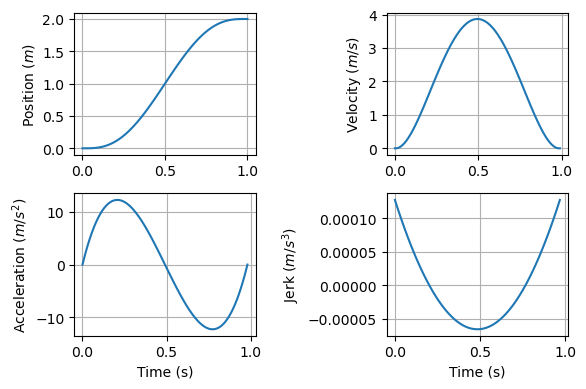

In [9]:
figure(figsize=(6, 4))
subplot(2,2,1)
plot(n, sol_pos)
ylabel(L"Position ($m$)"); grid()

subplot(2,2,2)
plot(n[1:nt-1], sol_vel)
ylabel(L"Velocity ($m/s$)"); grid()

subplot(2,2,3)
plot(n[1:nt-2], sol_accel)
ylabel(L"Acceleration ($m/s^2$)"); xlabel("Time (s)"); grid()

subplot(2,2,4)
plot(n[1:nt-3], sol_jerk)
ylabel(L"Jerk ($m/s^3$)"); xlabel("Time (s)"); grid()

tight_layout()

## 13.2.3 中継点を通る場合

In [10]:
via_point_pos = zeros(nt)'
via_point_pos[Int(nt/2)] = 1;

Aeq2 = [init_pos; final_pos; via_point_pos; init_vel; final_vel; init_accel; final_accel];

beq2 = zeros(7) # (init or final) or (pos, vel, acc) + via_point_pos = 2*3 + 1 = 7 
beq2[1] = 2 #inital position
beq2[2] = 4 #final position
beq2[3] = 6; #via point position

In [11]:
sol2_pos = solveEqualityConstrainedQuadProg(D_jerk' * D_jerk, zeros(nt), Aeq2, beq2);
sol2_vel = D_vel * sol2_pos;
sol2_accel = D_accel * sol2_pos;
sol2_jerk = D_jerk * sol2_pos;

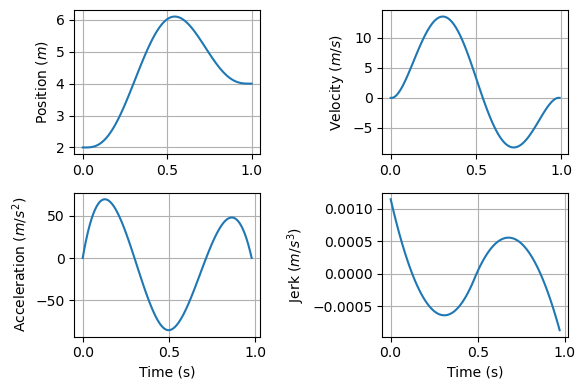

In [12]:
figure(figsize=(6, 4))
subplot(2,2,1)
plot(n, sol2_pos)
ylabel(L"Position ($m$)"); grid()

subplot(2,2,2)
plot(n[1:nt-1], sol2_vel)
ylabel(L"Velocity ($m/s$)"); grid()

subplot(2,2,3)
plot(n[1:nt-2], sol2_accel)
ylabel(L"Acceleration ($m/s^2$)"); xlabel("Time (s)"); grid()

subplot(2,2,4)
plot(n[1:nt-3], sol2_jerk)
ylabel(L"Jerk ($m/s^3$)"); xlabel("Time (s)"); grid()

tight_layout()